#**Bio Medical Image Analysis**

---

**Using Tensorflow, Keras, CNN.....**

**Kaggle API**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Downloding Data From Kaggle**

In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:24<00:00, 55.5MB/s]



In [ ]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

**Libraries**

In [ ]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# Tensorflow Keras
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Train, Test & Val Data**

In [ ]:
# Location of Train, Test & Val Data
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

**Define Standard Parameter Values**

In [ ]:
# Define Values
batch_size = 16
img_height = 500
img_width = 500

#**Preparing Data**

**Image Data Augmentation**

In [ ]:
image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               ) 

test_data_gen = ImageDataGenerator(rescale = 1./255)

train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
    test_path,
    target_size = (img_height, img_width),
    color_mode = 'grayscale', shuffle = False,
    class_mode = 'binary',
    batch_size = batch_size
)

valid = test_data_gen.flow_from_directory(
    valid_path,
    target_size = (img_height, img_width),
    color_mode = 'grayscale',
    class_mode = 'binary',
    batch_size = batch_size
)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


**Types of Data**

In [ ]:
# Type of Train
print("\nType of train : ",type(train))

# Type of Test
print("\nType of test : ",type(test))

# Type of Vali
print("\nType of vali : ",type(valid))


Type of train :  <class 'keras.preprocessing.image.DirectoryIterator'>

Type of test :  <class 'keras.preprocessing.image.DirectoryIterator'>

Type of vali :  <class 'keras.preprocessing.image.DirectoryIterator'>


#**Data Visualization of 10 Samples**

---
**Using matplotlib Library**


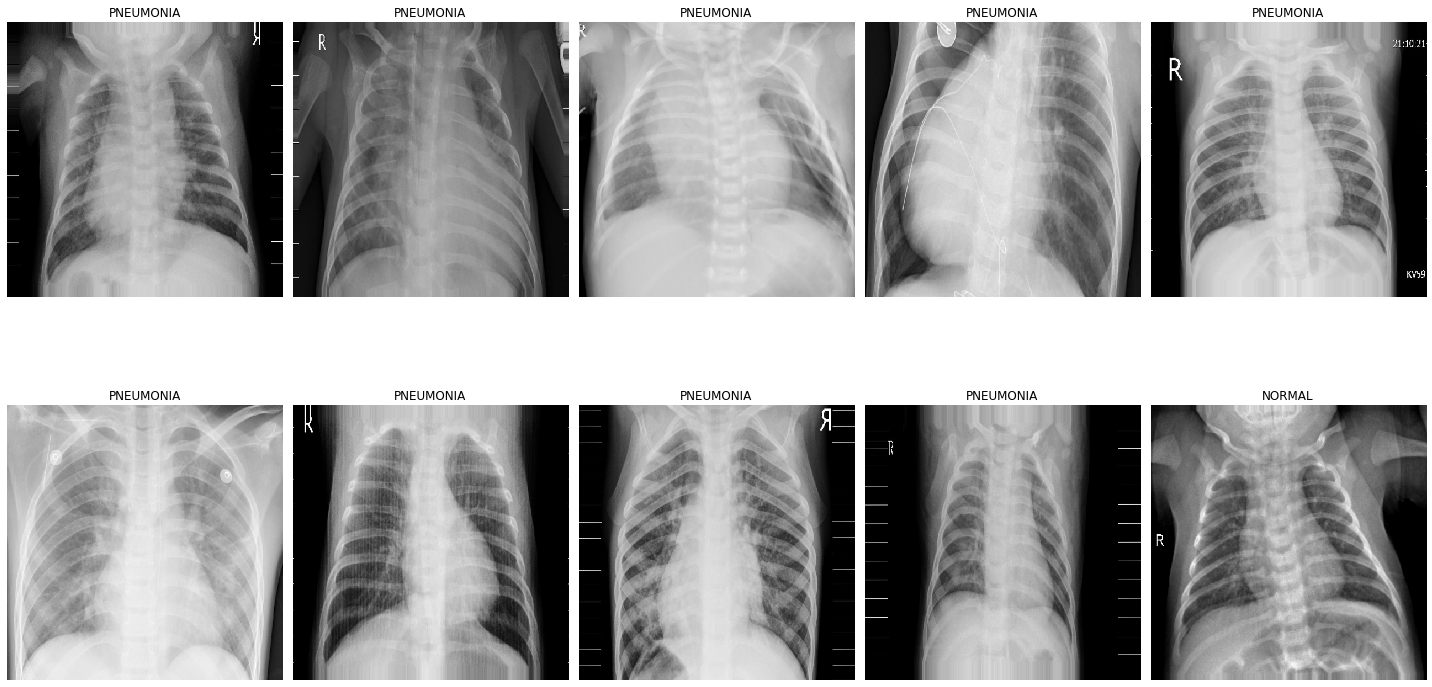

In [ ]:
# Data Visualization
plt.figure(figsize=(20,12))

for i in range(0,10):
  plt.subplot(2, 5, i+1)

  for X_batch, Y_batch in train:
    image = X_batch[0]
    dic = {0:'NORMAL', 1:'PNEUMONIA'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')
    plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')
    break

plt.tight_layout()
plt.show()

#**Convolutional Neural Network (CNN)**

In [ ]:
# Create CNN Model
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

**CNN Summary**

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

#**Plot The Model**

**Library**

In [ ]:
# Import Library
from tensorflow.keras.utils import plot_model

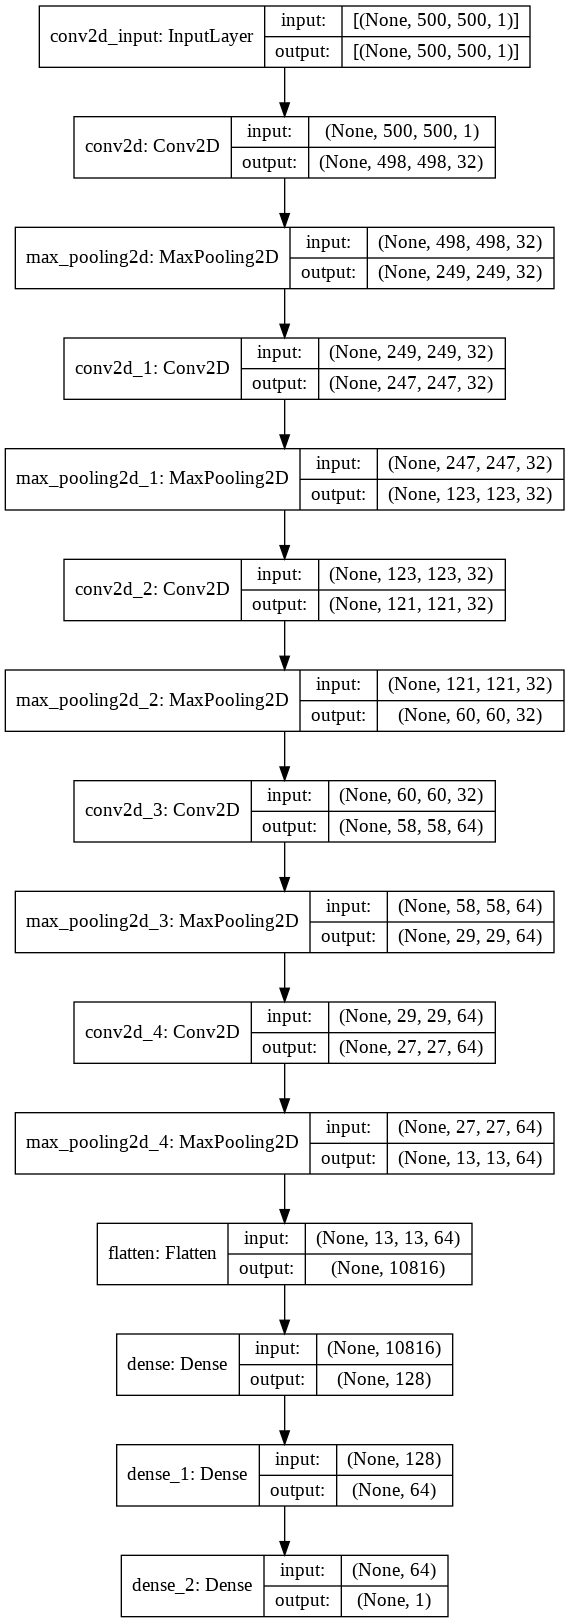

In [ ]:
# Plot Model
plot_model(cnn, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

#**Fit The Model**

In [ ]:
early = EarlyStopping(monitor = "val_loss",
                      mode = "min",
                      patience = 3
                      )

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_loss", patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

callbacks_list = [early, learning_rate_reduction]

**Library**

In [ ]:
# Import Library
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
# Fit Model
cnn.fit(train, epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 934s 4s/step - loss: 0.4578 - accuracy: 0.7405 - val_loss: 0.4764 - val_accuracy: 0.7606
Epoch 2/25
262/262 [==============================] - 939s 4s/step - loss: 0.2408 - accuracy: 0.9077 - val_loss: 0.2070 - val_accuracy: 0.9240
Epoch 3/25
262/262 [==============================] - 959s 4s/step - loss: 0.2086 - accuracy: 0.9148 - val_loss: 0.1967 - val_accuracy: 0.9260
Epoch 4/25
262/262 [==============================] - 958s 4s/step - loss: 0.1898 - accuracy: 0.9249 - val_loss: 0.2881 - val_accuracy: 0.8635
Epoch 5/25
262/262 [==============================] - 958s 4s/step - loss: 0.1826 - accuracy: 0.9234 - val_loss: 0.1488 - val_accuracy: 0.9375
Epoch 6/25
262/262 [==============================] - 960s 4s/step - loss: 0.1622 - accuracy: 0.9358 - val_loss: 0.1740 - val_accuracy: 0.9462
Epoch 7/25
262/262 [==============================] - 963s 4s/step - loss: 0.1596 - accuracy: 0.9385 - val_loss: 0.2029 - val_accuracy: 0.9308

#**Evaluation**

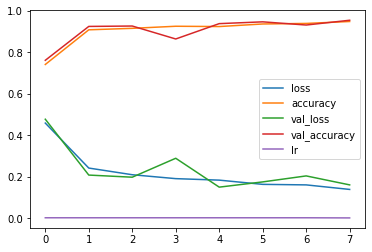

In [ ]:
# Plot Evaluation
pd.DataFrame(cnn.history.history).plot()

In [ ]:
# Test Accuracy
test_accu = cnn.evaluate(test)

print("\nTesting Accuracy : ",test_accu[1]*100,'%')

39/39 [==============================] - 37s 933ms/step - loss: 0.3352 - accuracy: 0.9071

Testing Accuracy :  90.70512652397156 %


In [ ]:
# Prediction
preds = cnn.predict(test, verbose=1)

39/39 [==============================] - 35s 878ms/step


In [ ]:
# Prediction
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

#**Confusion Matrix**

**Library**

In [ ]:
# Import Library
import seaborn as sb
from sklearn.metrics import classification_report, confusion_matrix

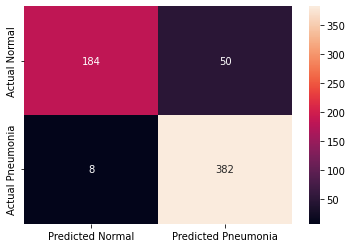

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(
    data = confusion_matrix(test.classes, predictions, labels=[0, 1]),
    index = ["Actual Normal", "Actual Pneumonia"],
    columns = ["Predicted Normal", "Predicted Pneumonia"]
)

# Heatmap Using Seaborn
sb.heatmap(cm, annot=True, fmt="d")

#**Classification Report**

---
**Precision, Recall, F1 - Score, Support**


In [ ]:
# Display Classification Report
print(classification_report(y_true=test.classes, y_pred=predictions, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.96      0.79      0.86       234
   Pneumonia       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



In [ ]:
# Reset Test
test.reset()

# X
x = np.concatenate([test.next()[0] for i in range(test.__len__())])

# Y
y = np.concatenate([test.next()[1] for i in range(test.__len__())])

# Display Shape of X & Y
print("\nX Shape : ",x.shape)
print("\nY Shape : ",y.shape)


X Shape :  (624, 500, 500, 1)

Y Shape :  (624,)


#**Final Result**

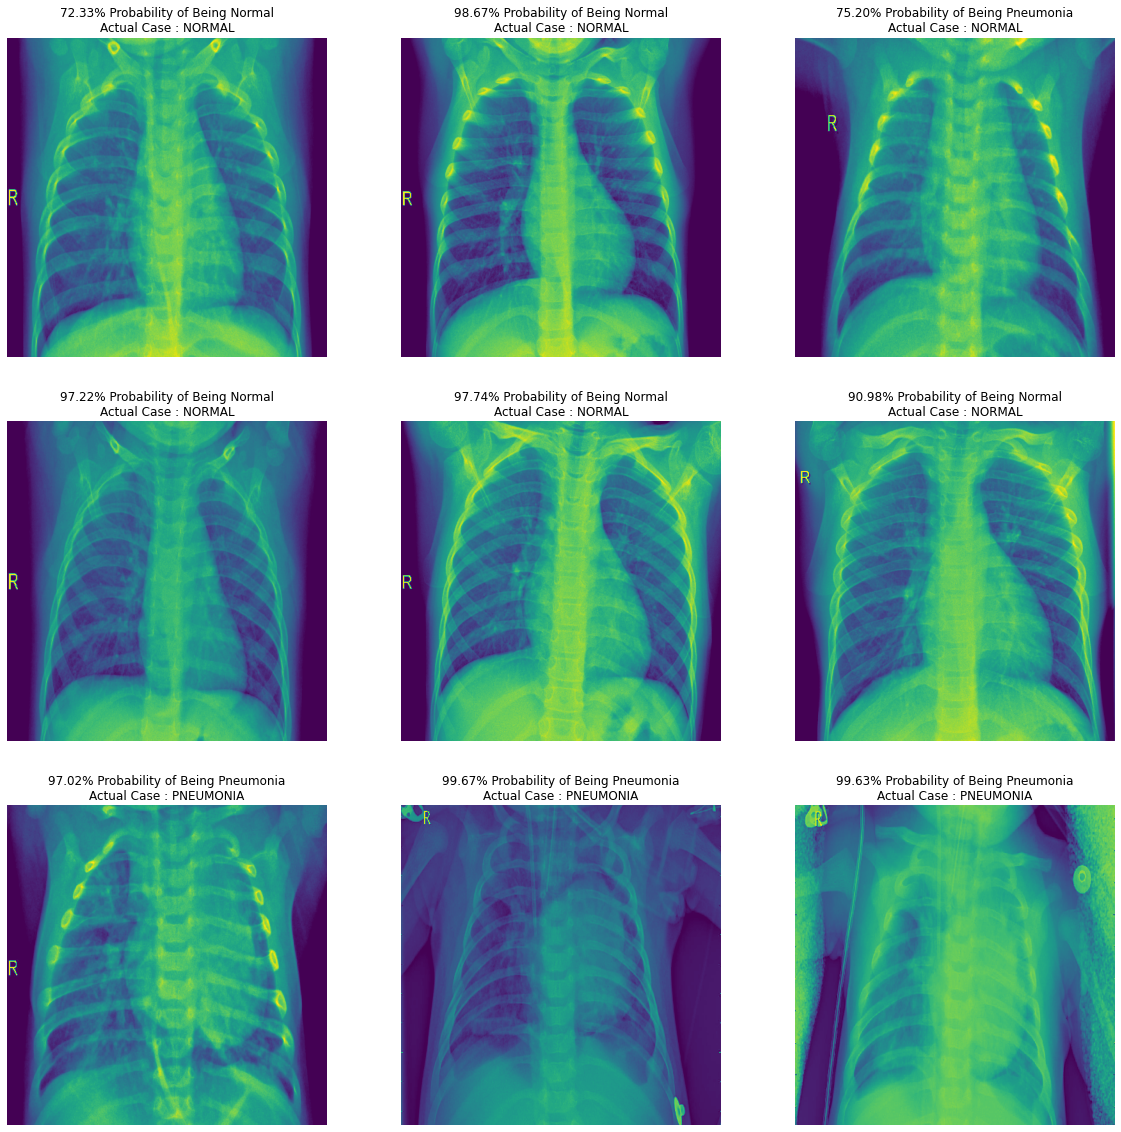

In [ ]:
# Final Result
dic = {0:'NORMAL', 1:'PNEUMONIA'}

# Plot
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} Probability of Being Pneumonia'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} Probability of Being Normal'.format(1-preds[i][0]))
      
      

  plt.title(out+"\nActual Case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')

# Display Plot
plt.show()

#**Testing On Own X - Ray Image**

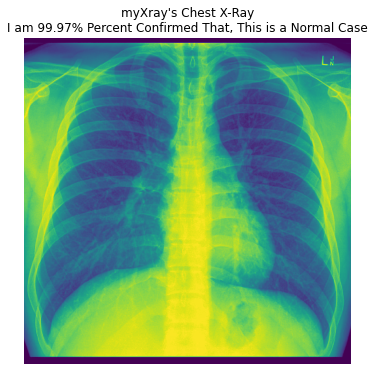

In [ ]:
# Testing with my own Chest X-Ray
myXray_path = '/content/drive/MyDrive/Dataset/MyXRay.jpg'

from tensorflow.keras.preprocessing import image

myXray_img = image.load_img(myXray_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_myXray_img = image.img_to_array(myXray_img)
pp_myXray_img = pp_myXray_img/255
pp_myXray_img = np.expand_dims(pp_myXray_img, axis=0)

#predict
myXray_preds= cnn.predict(pp_myXray_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if myXray_preds>= 0.5: 
    out = ('I am {:.2%} Percent Confirmed That, This is a Pneumonia Case !!'.format(myXray_preds[0][0]))
    
else: 
    out = ('I am {:.2%} Percent Confirmed That, This is a Normal Case'.format(1-myXray_preds[0][0]))
    

plt.title("myXray's Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_myXray_img))
plt.show()